# Plotting inverse limits algorithmically

In topology, an inverse limit is a topological space realized by taking a sequence of topological spaces $X_0,X_1,X_2,\ldots$ and a sequence of continuous functions $f_0,f_1,f_2,\ldots$ connecting the spaces in reverse order as in the figure below.  Points of the inverse limit space are sequences of points, one from each space, so that each function maps one corresponding point to the previous point in the sequence.  I.e. $f_i(x_{i+1})=x_i$ for each $i$.  The sequences can be finite, but things are most interesting when they are infinite.

$$X_0\overset{f_0}{\leftarrow} X_1\overset{f_1}{\leftarrow} X_2\overset{f_2}{\leftarrow} \cdots$$

Topology is filled with exotic "spaces" many of which have properties very different from the types of spaces studied in calculus and geometry, but some interesting inverse limits can be constructed using just the space formed by the closed unit interval $[0,1]$.  That is, we will begin by stipulating that each $X_i$ in the above figure is in fact $[0,1]$ and each function $f_i$ has domain $[0,1]$, range a subset of $[0,1]$, and is continuous as the word is defined in calculus.

$$[0,1]\overset{f_0}{\leftarrow} [0,1]\overset{f_1}{\leftarrow} [0,1]\overset{f_2}{\leftarrow} \cdots$$

Actually, there's nothing special here about $0$ and $1$.  In fact we could use any closed interval and the differences in the types of inverse limit spaces you would get would not matter to a topologist.  Mathematicians often use the unit interval by default when any closed interval will do, probably because $0$ and $1$ are important numbers as the additive and multiplicative identity.

Points in the these inverse limit spaces look like real number tuples as are commonplace in high school and undergraduate mathematics, but instead of being a tuple of two or three numbers, points in these spaces are tuples of infinitely many numbers, e.g. $(x_0,x_1,x_2,x_3,\ldots)$.  This means inverse limits technically sit in infinite dimensional space, though they are not necessarily themselves infinite dimensional.  To see this, imagine a set of infinite dimensional points, each point having the property that every number in the tuple is the same number, e.g. $(.2,.2,.2,.2,\ldots)$.  It's not hard to see this set of points is just a line segment, and is the inverse limit we get when each function in the inverse limit is defined to be the identity function $f(x)=x$.  A line segment is hardly an exotic infinite dimensional object.  So there is some hope of being able to visualize these objects that sit in infinite dimensional space.

We're going to use some code I wrote to visualize two well-known (to topologists) inverse limits.  This was originally written in MatLab and ported to Python.

## Limit class

Here's the code.  It's probably best to [skip to the demonstration](#demo) at first, but I've tried to document the code as well as possible for anyone who wants to dive in.

In [3]:
import numpy as np
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
from operator import le as less_eq
from itertools import tee

Some utility functions to make the main code more readable.

In [4]:
def adj_pairs(it):
    itr = iter(it)
    a = next(itr)
    for b in itr:
        yield a,b
        a = b

In [5]:
def issorted(it, compare = less_eq):
    a,b = tee(it)
    return all(map(compare,a,b))

In [6]:
def rev_enumerate(seq):
    return zip(range(len(seq)-1,-1,-1),reversed(seq))

The main code.

In [308]:
class BondingMap(object):
    def __init__(self, domains, ms, bs):
        """
        domains: Domain partition for the piecewise defined function.  
        
        ms: Slopes for each subdomain.

        bs: Constants for each subdomain.
        """
        assert issorted(domains) and domains[0] == 0.0 and domains[-1] == 1.0, \
            "Invalid domain partition.  Must begin with 0.0 and end with 1.0 and be in increasing order."
        assert len(domains)-1 == len(ms) == len(bs), \
            "Parameter and partition lengths don't match."
        for x,(end_m,start_m),(end_b,start_b) in zip(domains[1:-1],adj_pairs(ms),adj_pairs(bs)):
            assert end_m*x+end_b == start_m*x+start_b, \
                f"Function is discontinuous at {x}," + \
                f" {end_m}*{x}+{end_b} == {end_m*x+end_b} != {start_m*x+start_b} == {start_m}*{x}+{start_b}."
        
        self.domains,self.ms,self.bs = domains,ms,bs
    
    def __call__(self,x):
        """ Apply the bonding map to x. """
        assert 0.0 <= x <= 1.0, f"Function undefined at {x}."
        
        m,b = self.params(x)

        return m*x+b
    
    def params(self,x):
        """ Returns slope and constant parameters for the domain associated with x. """
        return next(((m,b) for end,m,b in zip(self.domains[1:],self.ms,self.bs) if x<=end))

In [291]:
class BondingMap2(object):
    def __init__(self, domains, ms, bs):
        """
        domains: Domain partition for the piecewise defined function.  
        
        ms: Slopes for each subdomain.

        bs: Constants for each subdomain.
        """
        assert issorted(domains) and domains[0] == 0.0 and domains[-1] == 1.0, \
            "Invalid domain partition.  Must begin with 0.0 and end with 1.0 and be in increasing order."
        assert len(domains)-1 == len(ms) == len(bs), \
            "Parameter and partition lengths don't match."
        for x,(end_m,start_m),(end_b,start_b) in zip(domains[1:-1],adj_pairs(ms),adj_pairs(bs)):
            assert end_m*x+end_b == start_m*x+start_b, \
                f"Function is discontinuous at {x}," + \
                f" {end_m}*{x}+{end_b} == {end_m*x+end_b} != {start_m*x+start_b} == {start_m}*{x}+{start_b}."
            
        self.domains = domains
        
        self.starts = np.array(domains[:-1])[...,None]
        self.ends = np.array(domains[1:])[...,None]
        self.ms,self.bs = np.array(ms)[...,None],np.array(bs)[...,None]
    
    def __call__(self,x):
        """ Apply the bonding map to x. """
#         assert 0.0 <= x <= 1.0, f"Function undefined at {x}."
        
#         m,b = self.params(x)

#         return (x*self.ms+self.bs)[((self.starts <= x) & (x < self.ends)) | (x == self.ends[-1:])]
        return (x*self.ms+self.bs)[((bm.starts <= x) & (x < bm.ends)) | (x == bm.ends * (2*np.eye(*bm.ends.shape)[::-1] - np.ones_like(bm.ends)))]

    
    def params(self,x):
        """ Returns slope and constant parameters for the domain associated with x. """
        return next(((m,b) for end,m,b in zip(self.domains[1:],self.ms,self.bs) if x<=end))

In [305]:
class Limit(object):
    """
    Limit class for visualization of inverse limits on the Hilbert cube.  Candidates
    must be obtainable using finitely piecewise linear bonding maps.
    """
    
    # Some constants defining different scaling rates.
    GEOMETRIC = 'geometric'
    HARMONIC = 'harmonic'
    
    def __init__(self, fs, repeats=True, iterations=5, pr=10, coord_met_dec=HARMONIC):
        """
        fs: A list of BondingMap objects representing the bonding maps of the limit.
        
        repeats: Flag indicating whether a single bonding map should be used repeatedly.
        If false, it is assumed all the bonding maps were given individually.
        
        iterations: In the case repeats == True, the number of iterations to apply to
        the given bonding maps.  If several bonding maps were given, they will all be 
        repeated <iterations> many times.  If repeats == False, this is ignored.
        
        prec: Precision to be used when comparing numbers to domain values.  This is only
        really necessary when we are deciding whether to split domain partitions.  Set to
        None to use machine precision.  Precision too low will cause domains to fail to 
        split when they should, but precision too high could cause splits due to 
        rounding errors.  Probably as long as it's not excessively low (like 2 or 3) it
        won't make much difference to the final plot and splits due to rounding error
        won't affect the plots at all.  On the other hand each split is potentially an 
        exponential increase in computation, so splits due to rounding errors could get 
        troublesome at high depths.
        
        coord_met_dec: Specifies the rate at which the Hilbert cube metric evaluation
        decreases as coordinates increase.  There's not a whole lot of qualitative or
        computational complexity difference between options, but the plots do change
        noticeably.  I've made harmonic the default because I think the plots are more
        clear.
        """
        for f in fs:
            assert isinstance(f,BondingMap)
        
        if coord_met_dec == Limit.GEOMETRIC:
            self.scale_f = lambda i:2**i
        elif coord_met_dec == Limit.HARMONIC:
            self.scale_f = lambda i:i+1
        else: 
            raise NameError(f"Scaling rate {coord_met_dec} is not recognized.")
        
        self.fs = fs*iterations if repeats else fs
        self.pr = pr
        self.n = n = len(self.fs) # length of the sequence for our approximation.
        
        # We need a pair of orthogonal vectors that will give us a 2-d view of
        # n+1 space.  Some views are better than others, but I chose a view
        # that keeps information about all coordinates and favors the first.
        # The criteria I used are:
        # - all coordinates of both vectors are non-zero
        # - orthanogality, i.e. np.dot(p,q) == 0 (up to rounding error)
        # - leading coordinate of each has largest magnitude (except in the edge case n=1).
        self.p = np.ones(n+1)
        self.p[0] = 2.0
        self.p[-1] = -1.0
        
        self.q = (3.0/(n+4.0)) * np.ones(n+1)
        self.q[0] = (-2.0 * n - 2.0)/(n + 4.0)
        self.q[1] = (n + 7.0)/(n + 4.0)
        self.q[-1] = -self.q[-1]
        
        # Getting the vectors can be computationally intensive, so we'll
        # generate them when make_vects() is called.
        self.vects_computed = False
        self.vects = None
    
    def make_vects(self):
        """
        Generate the vectors needed to plot the visualization.
        """
        partition = [0.0,1.0]
        for f in self.fs:
            # The idea here is, for every partition divider num, to find every number in the *next* 
            # coordinate that maps to it and make it a partition divider if it isn't already.
            add = []
            for num in partition:
                for j, ((start, end), m, b) in enumerate(zip(adj_pairs(f.domains),f.ms,f.bs)):
                    # Stepping through every linear subfunction, we take the inverse image of num and see
                    # if it in fact lies in the domain of the subfunction.  If so, we've found a number xnew
                    # that maps to num, so we'll remember it (along with the index where we want it) and 
                    # add it to the partition in the next coordinate.  
                    if m != 0: # Constant pieces aren't invertible but don't otherwise cause a problem.
                        xnew = (num - b) / m
                        if self.isbetween(xnew, start, end): # Looks like it's in the domain and not a divider!
                            add.append((xnew,j))
            # We need to sort the new dividers and insert them in reverse numerical order, 
            # so the indices we saved will be valid.
            add.sort(key = lambda o: o[0],reverse=True)
            print(f'add: {add}')
            for xnew,j in add:
                f.domains.insert(j+1,xnew)
                # We're technically creating a new subfunction by splitting one into two pieces, 
                # so we want the same slope and constant as the one we're splitting.
                f.ms.insert(j+1,f.ms[j])
                f.bs.insert(j+1,f.bs[j])
            partition = f.domains
            print(partition)
        
        # The fruit of our labor is a domain partition in every coordinate that is granular enough
        # so that each domain in the i+1st coordinate maps into exactly one domain in the ith 
        # coordinate.  That means if we map any given domain in the last coordinate up all the way
        # to the leading coordinate, the image in n dimensional space is a line segment.  This in 
        # turn means we can plot it by just joining adjacent vertices -- vertices which are 
        # obtained, in order, by mapping each dividing point in the nth coordinate in numerical order
        # successively through every coordinate using the appropriate bonding map to obtain the 
        # coordinates of a point in n+1-space.  So that's what we'll do, and store them in vects.
        vects = []
        for num in self.fs[-1].domains:
            v = np.zeros(self.n+1)
            v[-1] = num
            for i,f in rev_enumerate(self.fs):
                v[i] = f(v[i+1]) # Work backwards.
                
                # For our inverse limit to turn out looking right, we need to scale the coordinates to 
                # enforce the Hilbert cube metric (the scale of the ith coordinate decreases with i).  
                # A full explanation is outside the scope of this demonstration, but 
                # https://en.wikipedia.org/wiki/Hilbert_cube provides a brief synopsis.  Note we scale 
                # *after* we've hit the value with the bonding map, since the bonding maps are defined 
                # on the unscaled domain.
                self.scale(v,i+1)
                
            # A careful reading of the code reveals that we never scaled the leading coordinate
            # of v, but that's okay because the scaling factor is 1!
            vects.append(v)
        
        # Note these aren't points to use for plots, they are in a high dimensional space.
        self.vects_computed = True
        self.vects = np.asarray(vects)
        
        # Project the points into 2-d space using the vectors we created in __init__.
        self.xs = np.dot(self.vects, self.p)
        self.ys = np.dot(self.vects, self.q)
        
        # Now put it all together as a sequence of ordered pairs and store it in the class.
        self.vs = np.stack([self.xs,self.ys],-1)
        return self.vs
    
    def isbetween(self,x,a,b):
        """
        Working with floating point, there is the danger that due to rounding error,
        two numbers that should be the same aren't.  So we'll use this to approximate
        whether a number is between two others.
        
        Checks whether x is strictly between a and b looking at the first self.pr
        decimal places.  
        
        Alternatively, if self.pr is set to None, machine precision is used.
        """
        return (round(a-x,self.pr) < 0 < round(b-x,self.pr)) if self.pr is not None else a<x<b
    
    def scale(self,v,i):
        """ Scale in place the ith coordinate of vector v."""
        v[i] /= self.scale_f(i)
        
        return None

In [321]:
class Limit2(object):
    """
    Limit class for visualization of inverse limits on the Hilbert cube.  Candidates
    must be obtainable using finitely piecewise linear bonding maps.
    """
    
    # Some constants defining different scaling rates.
    GEOMETRIC = 'geometric'
    HARMONIC = 'harmonic'
    
    def __init__(self, fs, repeats=True, iterations=5, pr=10, coord_met_dec=HARMONIC):
        """
        fs: A list of BondingMap objects representing the bonding maps of the limit.
        
        repeats: Flag indicating whether a single bonding map should be used repeatedly.
        If false, it is assumed all the bonding maps were given individually.
        
        iterations: In the case repeats == True, the number of iterations to apply to
        the given bonding maps.  If several bonding maps were given, they will all be 
        repeated <iterations> many times.  If repeats == False, this is ignored.
        
        prec: Precision to be used when comparing numbers to domain values.  This is only
        really necessary when we are deciding whether to split domain partitions.  Set to
        None to use machine precision.  Precision too low will cause domains to fail to 
        split when they should, but precision too high could cause splits due to 
        rounding errors.  Probably as long as it's not excessively low (like 2 or 3) it
        won't make much difference to the final plot and splits due to rounding error
        won't affect the plots at all.  On the other hand each split is potentially an 
        exponential increase in computation, so splits due to rounding errors could get 
        troublesome at high depths.
        
        coord_met_dec: Specifies the rate at which the Hilbert cube metric evaluation
        decreases as coordinates increase.  There's not a whole lot of qualitative or
        computational complexity difference between options, but the plots do change
        noticeably.  I've made harmonic the default because I think the plots are more
        clear.
        """
        for f in fs:
            assert isinstance(f,BondingMap2)
        
        if coord_met_dec == Limit.GEOMETRIC:
            self.scale_f = lambda i:2**i
        elif coord_met_dec == Limit.HARMONIC:
            self.scale_f = lambda i:i+1
        else: 
            raise NameError(f"Scaling rate {coord_met_dec} is not recognized.")
        
        self.fs = fs*iterations if repeats else fs
        self.pr = pr
        self.n = n = len(self.fs) # length of the sequence for our approximation.
        
        # We need a pair of orthogonal vectors that will give us a 2-d view of
        # n+1 space.  Some views are better than others, but I chose a view
        # that keeps information about all coordinates and favors the first.
        # The criteria I used are:
        # - all coordinates of both vectors are non-zero
        # - orthanogality, i.e. np.dot(p,q) == 0 (up to rounding error)
        # - leading coordinate of each has largest magnitude (except in the edge case n=1).
        self.p = np.ones(n+1)
        self.p[0] = 2.0
        self.p[-1] = -1.0
        
        self.q = (3.0/(n+4.0)) * np.ones(n+1)
        self.q[0] = (-2.0 * n - 2.0)/(n + 4.0)
        self.q[1] = (n + 7.0)/(n + 4.0)
        self.q[-1] = -self.q[-1]
        
        # Getting the vectors can be computationally intensive, so we'll
        # generate them when make_vects() is called.
        self.vects_computed = False
        self.vects = None
    
    def make_vects(self):
        """
        Generate the vectors needed to plot the visualization.
        """
        partition = np.array([0.0,1.0])
        for f in self.fs:
            starts = f.starts
            ends = f.ends
            ms = f.ms
            bs = f.bs
            inv_images = (partition - bs) / ms
            partition = np.unique(
                np.concatenate([
                    inv_images[(starts <= inv_images) & (inv_images <= ends)],
                    starts.flatten(),
                    ends.flatten()
                ])
                
            )
        
        # The fruit of our labor is a domain partition in every coordinate that is granular enough
        # so that each domain in the i+1st coordinate maps into exactly one domain in the ith 
        # coordinate.  That means if we map any given domain in the last coordinate up all the way
        # to the leading coordinate, the image in n dimensional space is a line segment.  This in 
        # turn means we can plot it by just joining adjacent vertices -- vertices which are 
        # obtained, in order, by mapping each dividing point in the nth coordinate in numerical order
        # successively through every coordinate using the appropriate bonding map to obtain the 
        # coordinates of a point in n+1-space.  So that's what we'll do, and store them in vects.
        vects_lst = [partition]
        v = partition
        for i,f in rev_enumerate(self.fs):
            vects_lst.append(f(vects_lst[-1]))
        vects = np.stack(vects_lst[::-1], axis=-1)
        for i in range(vects.shape[1]):
            vects[:,i] /= self.scale_f(i)
#         for num in self.fs[-1].domains:
#             v = np.zeros(self.n+1)
#             v[-1] = num
#             for i,f in rev_enumerate(self.fs):
#                 v[i] = f(v[i+1]) # Work backwards.
                
#                 # For our inverse limit to turn out looking right, we need to scale the coordinates to 
#                 # enforce the Hilbert cube metric (the scale of the ith coordinate decreases with i).  
#                 # A full explanation is outside the scope of this demonstration, but 
#                 # https://en.wikipedia.org/wiki/Hilbert_cube provides a brief synopsis.  Note we scale 
#                 # *after* we've hit the value with the bonding map, since the bonding maps are defined 
#                 # on the unscaled domain.
#                 self.scale(v,i+1)
                
#             # A careful reading of the code reveals that we never scaled the leading coordinate
#             # of v, but that's okay because the scaling factor is 1!
#             vects.append(v)
        
        # Note these aren't points to use for plots, they are in a high dimensional space.
        self.vects_computed = True
        self.vects = np.asarray(vects)
        
        # Project the points into 2-d space using the vectors we created in __init__.
        self.xs = np.dot(self.vects, self.p)
        self.ys = np.dot(self.vects, self.q)
        
        # Now put it all together as a sequence of ordered pairs and store it in the class.
        self.vs = np.stack([self.xs,self.ys],-1)
        return self.vs
    
    def isbetween(self,x,a,b):
        """
        Working with floating point, there is the danger that due to rounding error,
        two numbers that should be the same aren't.  So we'll use this to approximate
        whether a number is between two others.
        
        Checks whether x is strictly between a and b looking at the first self.pr
        decimal places.  
        
        Alternatively, if self.pr is set to None, machine precision is used.
        """
        return (round(a-x,self.pr) < 0 < round(b-x,self.pr)) if self.pr is not None else a<x<b
    
    def scale(self,v,i):
        """ Scale in place the ith coordinate of vector v."""
        v[i] /= self.scale_f(i)
        
        return None

A function to make plotting things easy.

In [148]:
def lin_plot(vs,*args):
    assert len(args)%2 == 0, "Expected even number of axis views."
    for arg in args:
        assert len(arg) == 2, "Arguments >0 must be value range pairs."
        for x in arg:
            assert isinstance(x,float) or isinstance(x,int), \
                "Expected numerical values in value range pairs."
    
    xranges,yranges = args[0::2],args[1::2]
    fig = plt.figure(figsize=(4*len(xranges)+len(xranges), 4))
    
    n = len(xranges)
    
    for i,(xrange,yrange) in enumerate(zip(xranges,yranges)):
        ax = fig.add_subplot(1,n,i+1)

        path = patches.Path(vs)
        color = 'black'
        alpha = 1.0
        pathpatch = patches.PathPatch(path, facecolor='none', edgecolor=patches.colors.to_rgba(color,alpha))
        patch = ax.add_patch(pathpatch)
        ax.set_xlim(xrange[0],xrange[1])
        ax.set_ylim(yrange[0],yrange[1])
    plt.show()

<a id='demo'></a>

## Topologist's Sine Curve

We'll start with what's sometimes known as the [topologists sine curve](https://en.wikipedia.org/wiki/Topologist%27s_sine_curve).  This is an example of something that's connected (you can't partition it into two pieces that are separated by some distance) but not path-connected, meaning there are at least two points that can't be connected by a finite path that lies within the object.

Let's first generate the topologists sine curve using a traditional method.  For many inverse limits there may be well known ways of generating a visualization of the space we know we'll get, but these are usually very specialized while our class can be used to visualize any inverse limit (well, with a few caveats).

In [8]:
steps = 10000
xs = [i/steps for i in range(1,steps)]
sin_vs = [(x,np.sin(1/x)) for x in xs]

Here it is.  The left plot is the whole thing, while the right plot stretches out and zooms in the $x$-axis so it's clearer what's happening near $x=0$.  What looks like a solid bar is tightly packed oscillations of the curve.  How many oscillations?  Infinitely many, although we can only approximately plot it with a finite number of oscillations.  The line segment $x=0, -1\leq y\leq 1$ is also part of the topologist's sine curve, although I didn't plot it seperately here since it wouldn't be distinguishable from the oscillations anyway.

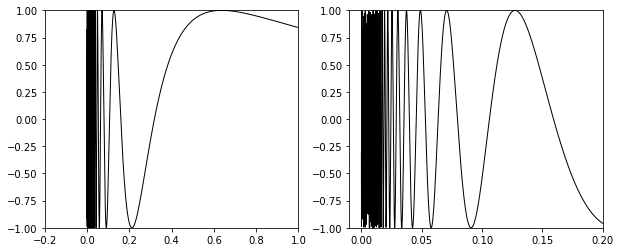

In [9]:
lin_plot(sin_vs,[-.2,1],[-1,1],[-.01,.2],[-1,1])

As I mentioned earlier, the topologists sine curve is not path connected: any point on the line segment $x=0,-1\leq y\leq 1$ is not reachable from any point on the oscillating part using a finite curve that stays in the plot.

It turns out that the topologists sine curve is an inverse limit.  Again, that means it arises from a system like:
$[0,1]\overset{f_0}{\leftarrow} [0,1]\overset{f_1}{\leftarrow} [0,1]\overset{f_2}{\leftarrow} \cdots$.
So the question is, what choice of continuous functions $f_0,f_1,f_2,\ldots$ (often called *bonding maps*) produces the object depicted above?

In [309]:
domains = [0.0, 2./3, 1.0]
ms = [1.5, -1.0]
bs = [0.0, 5./3]

In [310]:
f = BondingMap(domains,ms,bs)
tsc_map = [(x,f(x)) for x in f.domains]

The answer is, we make every bonding map the same function, using the function plotted below.

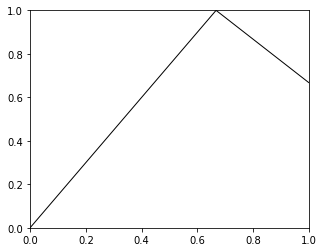

In [12]:
lin_plot(tsc_map,[0,1],[0,1])

This is a bit mysterious.  How do we get the crazy plot we saw earlier from a simple function like this?  This is the question that led me to write the code that I eventually ported to this notebook.

In [311]:
tsc = Limit([f],iterations=20)

In [322]:
f = BondingMap(domains,ms,bs)
f2 = BondingMap2(domains,ms,bs)

In [323]:
tsc2 = Limit2([f2], iterations=20)

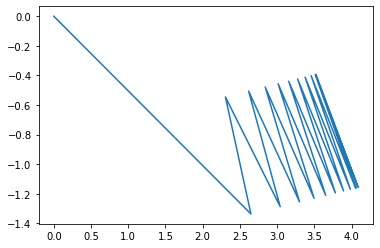

In [328]:
plt.plot(tsc2.xs, tsc2.ys)

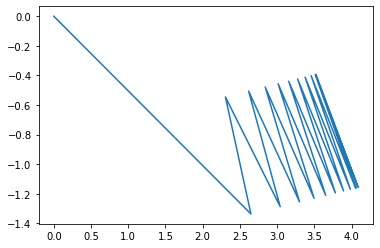

In [329]:
plt.plot(tsc.xs, tsc.ys)

In [333]:
tsc_vs = tsc2.make_vects()

Here is our visualization.  We can see the similar oscillation, but this is rotated and has sharp edges.  Is it really the same as what we saw earlier?  To a topologist, spaces are equivalent if one can be deformed into the other without joinings or breakings, and that's the case here.

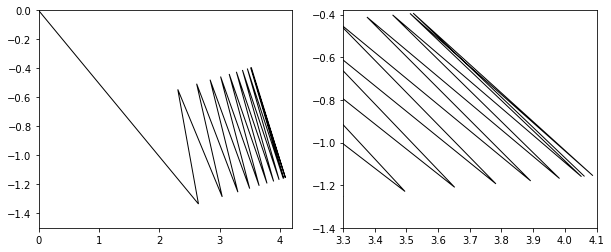

In [334]:
lin_plot(tsc_vs,[0,4.2],[-1.5,0],[3.3,4.1],[-1.4,-.38])

## Knaster Bucket-handle Continuum

<img align="left" src="https://upload.wikimedia.org/wikipedia/commons/3/30/The_Knaster_%22bucket-handle%22_continuum.svg" width="300" height="300" />

(This image is not my work, it was created by L. Rempe-Gillen and distributed under the Creative Commons License.  License information can be found [here](https://commons.wikimedia.org/wiki/File:The_Knaster_%22bucket-handle%22_continuum.svg).)

The other inverse limit space we will use the visualizer on is the Knaster bucket-handle.  The space is shown above.  It looks simple enough, until you zoom in to any of the strands.  In fact anything that your naked eye tells you is an isolated strand is actually a cluster of an infinite number strands, and no matter how far you zoom in, any given strand will be clustered together with as many strands as there are real numbers.  This space is a classic example of an indecomposible continuum, which means it can't be split into two smaller spaces that are connected and compact (compact means roughly that the space is in some sense small and has a clearly defined boundary).  This might sound strange, because it is.

In [335]:
domains = [0.0, 0.5, 1.0]
ms = [2.0, -2.0]
bs = [0.0, 2.0]

In [336]:
f = BondingMap(domains,ms,bs)
tent_map = [(x,f(x)) for x in f.domains]

This strange space can arise from an inverse limit that uses the following function for each of its bonding maps.  (This is sometimes called a tent map.)

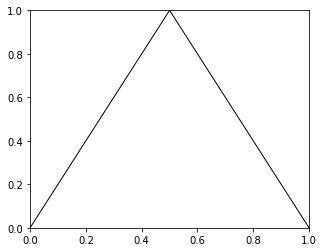

In [337]:
lin_plot(tent_map,[0,1],[0,1])

In [338]:
f2 = BondingMap2(domains,ms,bs)

In [339]:
kna = Limit([f],iterations=9)

In [340]:
kna2 = Limit2([f2],iterations=9)

In [341]:
kna_vs = kna.make_vects()

add: []
[0.0, 0.5, 1.0]
add: [(0.75, 1), (0.25, 0)]
[0.0, 0.25, 0.5, 0.75, 1.0]
add: [(0.875, 3), (0.625, 2), (0.375, 1), (0.125, 0)]
[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0]
add: [(0.9375, 7), (0.8125, 6), (0.6875, 5), (0.5625, 4), (0.4375, 3), (0.3125, 2), (0.1875, 1), (0.0625, 0)]
[0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
add: [(0.96875, 15), (0.90625, 14), (0.84375, 13), (0.78125, 12), (0.71875, 11), (0.65625, 10), (0.59375, 9), (0.53125, 8), (0.46875, 7), (0.40625, 6), (0.34375, 5), (0.28125, 4), (0.21875, 3), (0.15625, 2), (0.09375, 1), (0.03125, 0)]
[0.0, 0.03125, 0.0625, 0.09375, 0.125, 0.15625, 0.1875, 0.21875, 0.25, 0.28125, 0.3125, 0.34375, 0.375, 0.40625, 0.4375, 0.46875, 0.5, 0.53125, 0.5625, 0.59375, 0.625, 0.65625, 0.6875, 0.71875, 0.75, 0.78125, 0.8125, 0.84375, 0.875, 0.90625, 0.9375, 0.96875, 1.0]
add: [(0.984375, 31), (0.953125, 30), (0.921875, 29), (0.890625, 28), (0.859375,

In [349]:
len(kna.fs[0].domains)

513

In [351]:
partition = np.array(kna.fs[0].domains) # This partition decreases in size when acted on by f

Using the visualizer to get a two dimensional window into infinite-dimensional space, we get the plot below.  Instead of the rounded shape we saw earlier we have something more jagged, but again, the properties a topologist cares about are the same between this and the space depicted earlier.

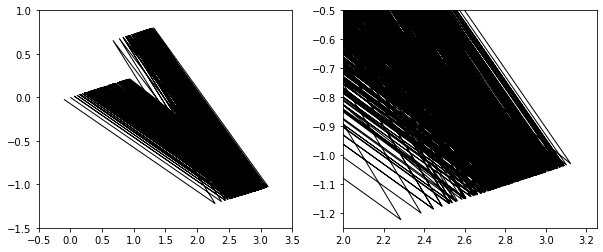

In [342]:
lin_plot(kna_vs,[-.5,3.5],[-1.5,1.],[2.,3.25],[-1.25,-.5])

In [343]:
kna_vs2 = kna2.make_vects()

ValueError: all input arrays must have the same shape

In [344]:
%debug

> /Users/alanbertl/projects/inv-limits/inv-limits-venv/lib/python3.8/site-packages/numpy/core/shape_base.py(427)stack()
    425     shapes = {arr.shape for arr in arrays}
    426     if len(shapes) != 1:
--> 427         raise ValueError('all input arrays must have the same shape')
    428 
    429     result_ndim = arrays[0].ndim + 1

ipdb> u
> <__array_function__ internals>(5)stack()

ipdb> u
> <ipython-input-321-adad38221eb2>(105)make_vects()
    103         for i,f in rev_enumerate(self.fs):
    104             vects_lst.append(f(vects_lst[-1]))
--> 105         vects = np.stack(vects_lst[::-1], axis=-1)
    106         for i in range(vects.shape[1]):
    107             vects[:,i] /= self.scale_f(i)

ipdb> [vect.shape for vect in vects_lst]
[(513,), (513,), (428,), (344,), (281,), (231,), (191,), (165,), (144,), (144,)]
ipdb> partition.shape
(513,)
ipdb> f(partition).shape
(513,)
ipdb> f(f(partition)).shape
(428,)
ipdb> q


Using the visualizer to get a two dimensional window into infinite-dimensional space, we get the plot below.  Instead of the rounded shape we saw earlier we have something more jagged, but again, the properties a topologist cares about are the same between this and the space depicted earlier.

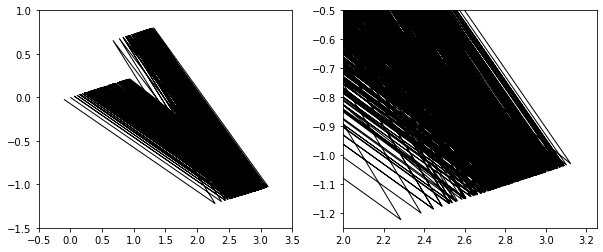

In [342]:
lin_plot(kna_vs,[-.5,3.5],[-1.5,1.],[2.,3.25],[-1.25,-.5])

## Other spaces?

Although I've only demonstrated the visualizer with two well-known spaces, it can be used to visualize any inverse limit where the coordinate spaces are all $[0,1]$ and the bonding maps are finitely piecewise linear -- that is, you can plot the bonding maps using a finite number of line segments joined together at their ends.  The easiest way to define a Limit object is by first defining the distinct bonding maps to use.  Bonding maps are defined using three lists.

The first list defines the piecewise domains -- the domains of each of the line segments.

So what's being defined below is a bonding map that uses a line segment stretching from $x=0$ to $x=0.5$, and potentially a different line segment stretching from $x=0.5$ to $x=1.0$.  Note that the list should begin with $0$ and end with $1$ and be in increasing order.

In [22]:
domains = [0.0,0.5,1.0]

The next list defines the slopes of the line segments.  Since the line segments stretch between the $x$ values given above, there should be one fewer element of this list than the list above.

In [23]:
ms = [-2.0,1.0]

The final list defines the constants for each line segment.  The length of this list should be equal to the length of the slope list, and one less than the length of the domain list.

In [24]:
bs = [1.0,-0.5]

Now we construct a BondingMap:

In [25]:
f = BondingMap(domains,ms,bs)

Plotting it is easy.  The bonding map is callable, and since it is piece-wise linear, we need only get the $(x,y)$ pairs for $x$ values in the domains list and then plot a path.

In [26]:
f_map = [(x,f(x)) for x in f.domains]

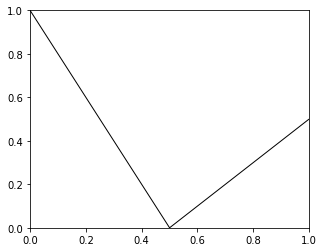

In [27]:
lin_plot(f_map,[0,1],[0,1])

For fun, let's create a second bonding map and use both maps to create an inverse limit.

In [28]:
domains,ms,bs = [0.0,.25,.75,1.0],[4.0,-2.0,4.0],[0.0,1.5,-3.0]

In [29]:
g = BondingMap(domains,ms,bs)

In [30]:
g_map = [(x,g(x)) for x in g.domains]

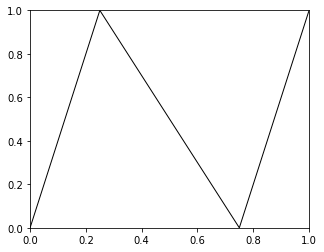

In [31]:
lin_plot(g_map,[0,1],[0,1])

We'll define a Limit object the bonding maps of which alternates back and forth between these two maps.  We use the iterations argument when we want to repeat the bonding maps over and over.  By specifying 4 iterations, the class will alternate between both bonding maps four times, for a total of 8 bonding maps.  We have to be careful not to set iterations too high, as the computation time can grow *exponentially* with approximation depth.  Earlier I was able to go up to 20 iterations with the topologists sine curve, as it's computational complexity isn't as bad, while I had to be a little more conservative with the bucket-handle.  Here since I've got two bonding maps the depth is double the iterations so I've kept iterations low.

In [32]:
weird = Limit([f,g],iterations=4)

In [33]:
weird_vs = weird.make_vects()

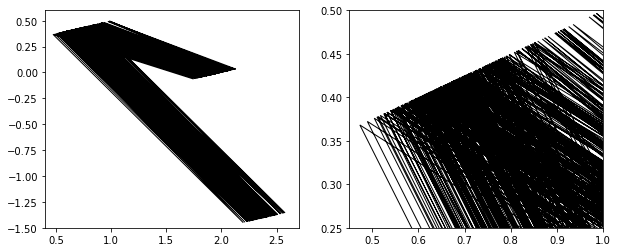

In [34]:
lin_plot(weird_vs,[.4,2.7],[-1.5,.6],[.45,1.],[.25,.5])

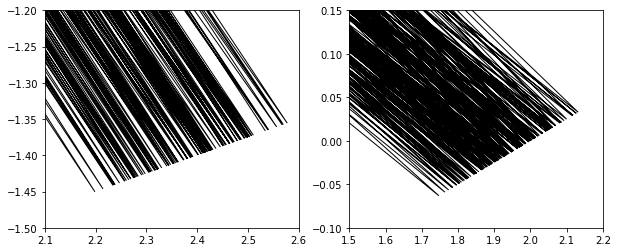

In [35]:
lin_plot(weird_vs,[2.1,2.6],[-1.5,-1.2],[1.5,2.2],[-.1,.15])

At a glance it looks similar to the bucket-handle, which is either interesting or boring depending on what you're looking for.  This is only very coarse information to a topologist who would have to do some careful analysis if this is their first look at the inverse limit.  On the other hand if a topologist already knew something about a class of spaces to which this belonged, they might be able to confirm or deny a hypothesis with a quick look.

You can download this notebook <a href="https://alanbertl.com/wp-content/uploads/2018/11/inverse-limits.ipynb" download>here</a>.  You'll need [Jupyter](https://jupyter.org/).